# PCA & LDA

This is a short demonstration where I familiarized myself with PCA and LDA with the scikit-learn library. PCA is a technique for identifying low-dimensional manifolds. Below is a simple example and demonstrates the variance explained by each of the selected components (where n_components = 2). Thus, PCA decomposes the dataset in a set of successive orthogonal components that explain the maximum amount of variance. More about PCA can be found on http://scikit-learn.org/stable/modules/decomposition.html#decompositions

In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pylab as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Simple example which as a warmup

In [39]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pcaSimple = PCA(n_components=2)
pcaSimple.fit(X)

print(pcaSimple.explained_variance_ratio_) 

[0.99244289 0.00755711]


# Iris data set

I will now use a wellknown dataset, also known as the iris data set, where more information can be found on it at http://archive.ics.uci.edu/ml/datasets/Iris. 

The data set is imported through using load_iris2.py from the provided load_iris python module. This converts the class labels to numbers and since there are 3 classes, they are labelled 0, 1, and 2. 

The data is fit with PCA and I investigate what happens when I fit the data with 3 principal components to see how much of the variance is explained by these components.

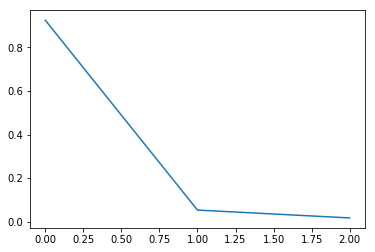

[0.92461872 0.05306648 0.01710261]


In [40]:
#Load the data
from sklearn.datasets import load_iris
iris_data = load_iris()
data = iris_data.data
labels = iris_data.target
classes = set(labels)

#Fit the data with PCA
pcaIris = PCA(n_components=3)
pcaIris.fit(data)
plt.plot(pcaIris.explained_variance_ratio_)
plt.show()
print(pcaIris.explained_variance_ratio_)

# Projecting the data

The data is now projected onto the first two principal components. Now it is visible to see how much class seperation is obtained through projecting onto the first two principal components.

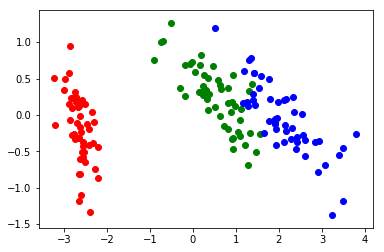

In [41]:
pca = PCA(n_components=2)
x2 = pca.fit(data).transform(data)
plt.figure()
c = ['r','g','b']
for i in range(0,3):
    plt.scatter(x2[labels == i, 0], -x2[labels == i, 1], color = c[i])
plt.show()

# Face recognition

The next part introduces facial recognition through using eigenfaces, see https://en.wikipedia.org/wiki/Eigenface 

The code demonstrates the main ideas of the eigenface approach using the Olivetti face database.

In [42]:
from skimage import io
ic = io.ImageCollection('../data/att_faces/*/*.png')
ic = np.array(ic)
ic_flat = ic.reshape((len(ic), -1))
number,m,n = ic.shape 
print(ic.shape)

(399, 112, 92)


## Viewing the faces

Using iPython widgets, the faces can be viewed by importing an image viewer

In [43]:
from ipywidgets import interact

def view_image(n=0):
    plt.imshow(ic[n], cmap='gray', interpolation='nearest')
    plt.show()

w = interact(view_image, n=(0, len(ic)-1))

interactive(children=(IntSlider(value=0, description='n', max=398), Output()), _dom_classes=('widget-interact'…

An investigation is now done as to how many principal components are needed to capture a significant amount of information of a face. The ratio of total variance explained by n components is calculated, where n is selected as n=200 and is plotted below.

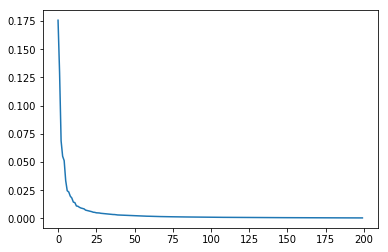

In [44]:
pcaFaces = PCA(n_components=200)
pcaFaces.fit(ic_flat)
plt.plot(pcaFaces.explained_variance_ratio_)
plt.show()

### Projecting the faces onto the eigenfaces

All the images are projected onto the 200 eigenfaces defined above. To visualise what information is lost, the projected images are projected back onto the original space, reshaped and then displayed.

In [45]:
pr_ic_flat = pcaFaces.transform(ic_flat)
back_pr_ic_flat = pcaFaces.inverse_transform(pr_ic_flat)

Restore flattened array into its original shape and view the restored images. The images are reduced from 10304 to 200.

In [46]:
ic_restore = back_pr_ic_flat.reshape((number,m,n))

def view_image(n=0):
    plt.imshow(ic_restore[n],cmap='gray', interpolation='nearest')
    plt.show()

w = interact(view_image, n=(0, len(ic)-1))

interactive(children=(IntSlider(value=0, description='n', max=398), Output()), _dom_classes=('widget-interact'…

### Projecting something else

Previously, the faces were represented used to derive the eigenfaces in terms of the eigenfaces. Now the attention is shifted to faces not part of the training set.

Now, someone elses face is used and the same procedure is followed as above 

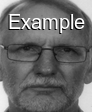

In [47]:
ben = io.ImageCollection('../resources/images/Ben_bw.png')[0]
ben = np.array(ben)
display(Image(filename='../resources/images/Ben_bw_wm.png'))

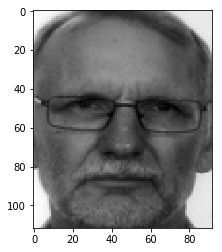

In [48]:
#code to produce the image below (from the array!)
plt.imshow(ben, cmap='gray', interpolation='nearest')
plt.show()

Flatten the face, project it onto 200 eigenfaces, restore it from the projection and display.

(112, 92)
(1, 10304)


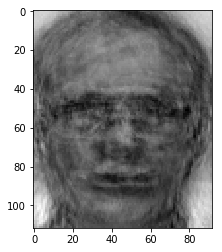

In [49]:
ben_flat = ben.reshape((1, -1))
print(ben.shape)
print(ben_flat.shape)
m,n = ben.shape
pcaben = PCA(n_components=200)
pcaben.fit(ic_flat)
pr_ben_flat = pcaben.transform(ben_flat)
back_pr_ben_flat = pcaben.inverse_transform(pr_ben_flat)
ben_restore = back_pr_ben_flat.reshape((m,n))
plt.imshow(ben_restore,cmap='gray', interpolation='nearest')
plt.show()

## Signatures

The next section builds a signature verification system. Signatures vary as to the origin of whatever coordinate system we use, the size and (in-plane) rotation. The system could recognize signatures at different positions, sizes and rotations but will complicate the system and demand a large training set representing different scenarios. Instead, it is easier to do pre-processing normalizing signatures. This might fail on some signatures, but PCA is still a valuable tool for doing this and shows the underlying mechanism of the singular value decomposition (SVD).

The signatures captures the x and y coordinates, pen pressure, pen angle(tilt) and pen direction. Only the x and y coordinates (which are the first two features) are used from the provided data.

The code calculates the SVD of the signature (just for x and y coordinates). Then, the SVD is used to transform the original signature data. The data is rotated, scaled so that the standard deviation along the first principal axis equals 1 and finally the data is whitened. 

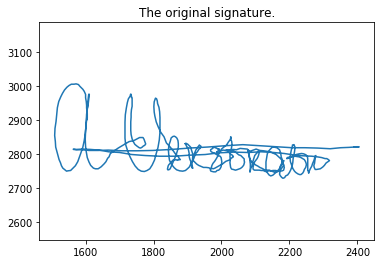

In [50]:
sign_full = np.loadtxt('../data/sign/sign3/sigtrain3_1.txt',comments = '%')  # Read Signature

sign = sign_full[:,:2].T
plt.plot(sign[0,:],sign[1,:])
plt.axis('equal')
plt.title('The original signature.')
plt.show()

### Removing the mean

To center the signature, the mean is removed, i.e. normalizes it with respect to position

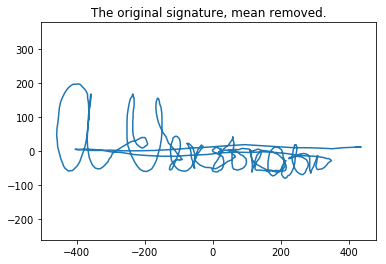

In [51]:
d,n = sign.shape
mean = np.mean(sign,axis=1)[:,np.newaxis]
sign = (sign - mean)

plt.plot(sign[0,:],sign[1,:])
plt.axis('equal')
plt.title('The original signature, mean removed.')
plt.show()

### Calculating the principal components

The principal components are calculated using the SVD. The principal directions as well as one standard deviation is illustrated through calculating the one standard deviation ellipse, aligned along the principle directions.

In [52]:
# Define Circle
ang = np.linspace(0,2*np.pi,500)
x = np.cos(ang); y = np.sin(ang)
circ = np.vstack((x,y))

# Calculate the principal directions using the SVD
u, s, vh = np.linalg.svd(sign,full_matrices=False)


# Ellipse aligned with principal directions, one standard deviation intersect.
# Note scaling of singular values so that scaled values express the standard deviations.
ell = u.dot(np.diag(s/np.sqrt(n))).dot(circ)

### Getting the sign right

The sign of the eigenvectors (principal directions) is not determined, which means there is no way of predicting whether they are returned with a specific sign. Thus, if the sign is wrong, it will be reflected around the coordinate axis. Thus, it is necessary to check whether the sign is correct, and if not, flip it. It is thus convenient to assume that the signatures are produced from left to right. This means that the x component of the first principal direction, and the y coordinate of the second principal direction should be positive. It does not work for all cases, but hopefully for most.

[[-0.98734389  0.15859398]
 [ 0.15859398  0.98734389]]


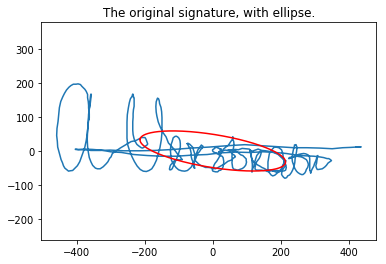

In [53]:
print(u)
sgn = np.sign(u[0,0])
u[:,0] = sgn*u[:,0]
vh[0,:] = sgn*vh[0,:]

sgn = np.sign(u[1,1])
u[1,:] = sgn*u[1,:]
vh[1,:] = sgn*vh[1,:]

plt.plot(sign[0,:],sign[1,:])
plt.plot(ell[0,:],ell[1,:],'r')
plt.axis('equal')
plt.title('The original signature, with ellipse.')
plt.show()

### Rotating the signature

Using the SVD components, the signature is rotated so that the principal axis coincide with the coordinate axis.

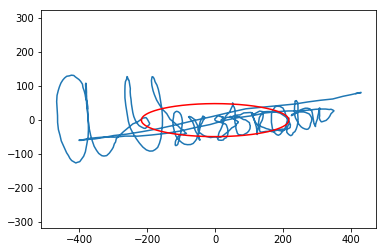

In [54]:
diag_sigma = np.diag(s)
rotated = diag_sigma.dot(vh)
rotatedell= u.T.dot(ell)

plt.plot(rotated[0,:],rotated[1,:])
plt.plot(rotatedell[0,:],rotatedell[1,:],'r')
plt.axis('equal')
plt.show()

### Scale the signature

The signature is now scaled,whilst preserving the aspect ratio so that the standard deviation along the first principal directions equal 1

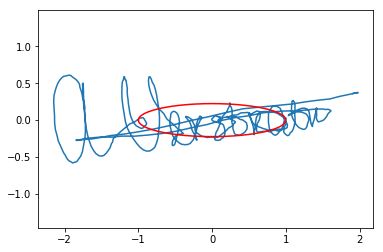

In [57]:
scaled_sign=rotated*(np.sqrt(n)/np.max(s))
scaled_ell=rotatedell*(np.sqrt(n)/np.max(s))

plt.plot(scaled_sign[0,:],scaled_sign[1,:])
plt.plot(scaled_ell[0,:],scaled_ell[1,:],'r')
plt.axis('equal')
plt.show()

### Whiten the signature

The signature is now scaled, without preserving the aspect ratio so that the standard deviation along the first principal directions equal 1

[216.85539297  48.54046555]
[1.         0.22383795]


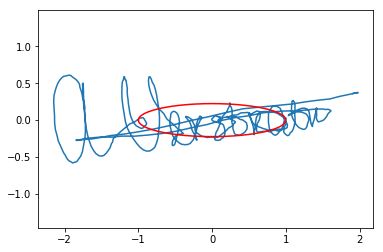

In [59]:
scaled_sign=rotated*(np.sqrt(n)/np.max(s))
scaled_ell=rotatedell*(np.sqrt(n)/np.max(s))

print((1/np.sqrt(n))*s)
print(s/np.max(s))

plt.plot(scaled_sign[0,:],scaled_sign[1,:])
plt.plot(scaled_ell[0,:],scaled_ell[1,:],'r')
plt.axis('equal')
plt.show()

# Linear Discriminant Analysis (LDA)

PCA above can be seen as a dimensionality reduction scheme, projecting onto directions with maximum variance.

LDA is also a dimensionality reduction scheme, but operates on a different principle. The data is now labelled according to the different classes they belong to. An input *x* and a class label *y* is given corresponding to *x* for each data point. If there are *k* classes, *y* will take on one of *k* values (0 through *k-1* in Python).

The idea now is to project data onto a lower-dimensional space in such a way that maximal class seperation is achieved in the lower dimensional space. Therefore, the axis system we choose will distinguis class membership, instead of only maximizing the variance. More about the scikit-learn implementation can be found on http://scikit-learn.org/stable/modules/generated/sklearn.lda.LDA.html

## Simple example

The following is a warmup example from the scikit-learn website. The code predicts class labels for samples in X.

In [70]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])
clf = LDA()
clf.fit(X, y)
print(X)
print(y)
print(clf.predict([[-0.8, -1]]))
print(clf.predict([[2, 3]]))

[[-1 -1]
 [-2 -1]
 [-3 -2]
 [ 1  1]
 [ 2  1]
 [ 3  2]]
[1 1 1 2 2 2]
[1]
[2]


## Wine data set

The difference between PCA and LDA is now investigated through using the wine data set - http://archive.ics.uci.edu/ml/datasets/Wine. The wine data set is 13-dimensional, so the difference between PCA and LDA is more pronounced than the iris data set.

It is only projected down to 2 dimensions for easy visualisation. Since there are only 3 classes, one does not retaing any more information through using higher dimensions.

### Loading the data

Read the data, extract the class labels from the last column, and extract the names of classes using the `set` type

In [72]:
wine_train = np.loadtxt('../data/wine/wine_train.txt',delimiter = ',')
wine_train_labels = wine_train[:,-1]
wine_train_classes = list(set(wine_train_labels))
wine_train_classes = np.array(wine_train_classes,dtype=int)
wine_train_labels = np.array(wine_train_labels,dtype = int)
wine_train = wine_train[:,:-1]

wine_test = np.loadtxt('../data/wine/wine_test.txt',delimiter = ',')
wine_test_labels = wine_test[:,-1]
wine_test_classes = list(set(wine_test_labels))
wine_test_classes = np.array(wine_test_classes,dtype=int)
wine_test_labels = np.array(wine_test_labels,dtype = int)
wine_test = wine_test[:,:-1]

## PCA

#### The data is first projected onto 2 PCA components and displays the classes of the dimension-reduced data

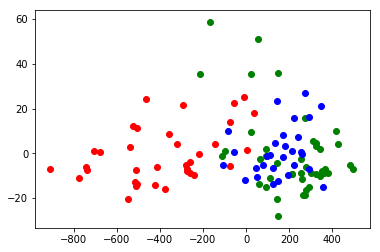

In [73]:
PCA_wine = PCA(n_components=2)


xWine = PCA_wine.fit(wine_train).transform(wine_train)

plt.figure()
c = ['r','g','b']
for i in range(1,4):
    plt.scatter(-xWine[wine_train_labels == i, 0], xWine[wine_train_labels == i, 1], color = c[i-1])
plt.show()

## LDA

#### An LDA model is fit to the data, using 2 components and displays the different classes of the projected data

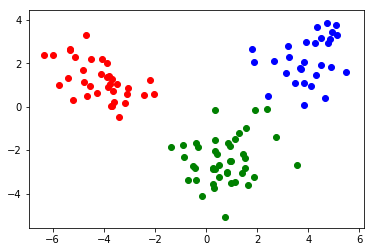

In [74]:
clfWine = LDA()
LDAwine = clfWine.fit_transform(wine_train, wine_train_labels)

plt.figure()
c = ['r','g','b']
for i in wine_train_classes:
    plt.scatter(LDAwine[wine_train_labels == i, 0], LDAwine[wine_train_labels == i, 1], color = c[i-1])

plt.show()